In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from cheyette.curves import FlatCurve
from cheyette.products import PayerSwaption, PayerSwaptionAnnuity
from cheyette.processes import VasicekProcess, QuadraticAnnuityProcess
from cheyette.discretization import PeacemanRachford
from cheyette.boundary_conditions import DirichletIntrinsicBC
from cheyette.models import CheyettePDEModel, CheyetteAnalyticModel
from cheyette.pricers import CheyettePricer

plt.style.use('input/qulib.mplstyle')

In [9]:
curve = FlatCurve(short_rate=0.01)
process = VasicekProcess(mean_rev=0.10, local_vol=0.01)
process_annuity = QuadraticAnnuityProcess(mean_rev=0.01, a=0.01, b=0.00, c=0.00)

model_pde = CheyettePDEModel(x_grid_stddevs=5.0, y_grid_stddevs=5.0,
                    x_freq=3, y_freq=3, t_freq=10,
                    stepping_method=PeacemanRachford(),
                    x_lower_bc=DirichletIntrinsicBC(), x_upper_bc=DirichletIntrinsicBC(),
                    y_lower_bc=DirichletIntrinsicBC(), y_upper_bc=DirichletIntrinsicBC())

underlying_times = [1.0, 2.0, 3.0]
strike = curve.swap_rate(underlying_times)
expiry = 1.0
product = PayerSwaption(strike=strike, expiry=expiry, underlying_times=underlying_times)
product_annuity = PayerSwaptionAnnuity(strike=strike, expiry=expiry, underlying_times=underlying_times,
                                  curve=curve, process=process_annuity)

valuation_time = 0.0
pricer = CheyettePricer(model_pde, curve, process, product, valuation_time=valuation_time)
pricer_annuity = CheyettePricer(model_pde, curve, process_annuity, product_annuity, valuation_time=valuation_time)

notional = 10000.0

pv = pricer.price()['PV']*notional
pv_annuity = pricer_annuity.price()['PV']*notional

print(f'PV: {pv}')
print(f'PV Annuity: {pv_annuity}')
print(f'Abs. Error: {pv - pv_annuity}')

PV: 67.41889576129677
PV Annuity: 76.48982391846774
Abs. Error: -9.070928157170968


# Curve Shifts

In [10]:
short_rates = np.arange(-0.05, 0.0501, 0.01)
curves = [FlatCurve(r) for r in short_rates]
products_annuity = [PayerSwaptionAnnuity(strike, expiry, underlying_times, x, process_annuity) for x in curves]

pvs_curve = [pricer.set('curve', x).price()['PV']*notional for x in curves]
pvs_curve_annuity = [pricer_annuity.set('curve', x).set('product', y).price()['PV']*notional 
                     for x, y in zip(curves, products_annuity)]

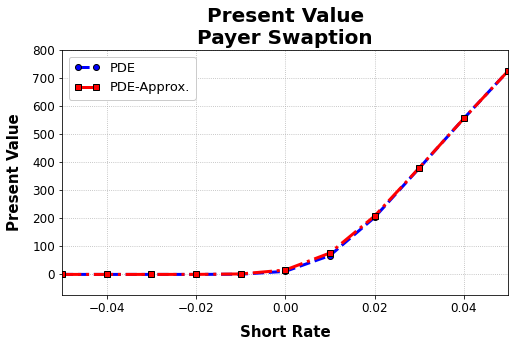

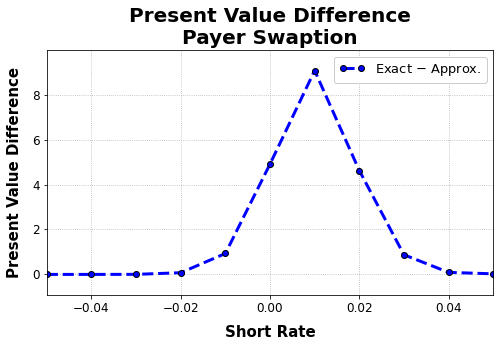

In [17]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, pvs_curve, label='PDE')
ax.plot(short_rates, pvs_curve_annuity, label='PDE-Approx.')
ax.set_xlabel('Short Rate')
ax.set_ylabel('Present Value')
ax.set_title('Present Value\nPayer Swaption')
ax.legend()


diff = [y - x for x, y in zip(pvs_curve, pvs_curve_annuity)]
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, diff, label='Exact $-$ Approx.')
ax.set_xlabel('Short Rate')
ax.set_ylabel('Present Value Difference')
ax.set_title('Present Value Difference\nPayer Swaption')
ax.legend()

# Vol Shifts

In [13]:
mults = np.arange(-0.9, 2.1, 0.1)
default_vol = 0.02
processes = [VasicekProcess(mean_rev=0.01, local_vol=(1 + m) * default_vol) for m in mults]
processes_annuity = [QuadraticAnnuityProcess(mean_rev=0.01, a=(1 + m) * default_vol, b=0.00, c=0.00) for m in mults]
products_annuity = [PayerSwaptionAnnuity(strike, expiry, underlying_times, curve, y) for y in processes_annuity]

pvs_vols = [pricer.set('process', x).price()['PV']*notional for x in processes]
pvs_vols_annuity = [pricer_annuity.set('process', x).price()['PV']*notional for x in processes_annuity]

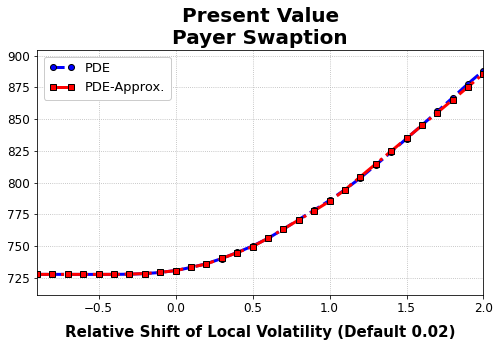

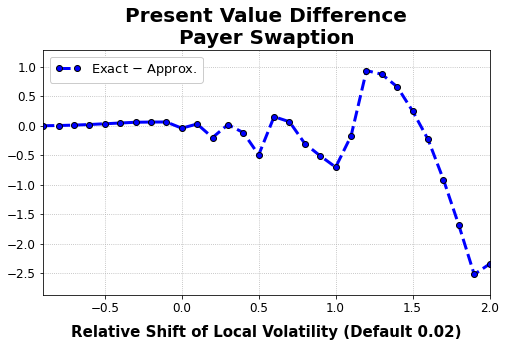

In [18]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(mults, pvs_vols, label='PDE')
ax.plot(mults, pvs_vols_annuity, label='PDE-Approx.')
ax.set_xlabel(f'Relative Shift of Local Volatility (Default {default_vol})')
ax.set_title('Present Value\nPayer Swaption')
ax.legend()

diff = [y - x for x, y in zip(pvs_vols, pvs_vols_annuity)]
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(mults, diff, label='Exact $-$ Approx.')
ax.set_xlabel(f'Relative Shift of Local Volatility (Default {default_vol})')
ax.set_title('Present Value Difference\nPayer Swaption')
ax.legend()